# Notebook for log parsing

In [ ]:
import os
import re

logs = '/mnt/DADES/home/pmedina/tfg/src/raw_runs/logs/'

## Create the functions that will compute the metrics

In [2]:
import editdistance
from collections import Counter

def character_error_rate(prediction, ground_truth):
    """
    CER = (Substitutions + Insertions + Deletions) / len(ground_truth)
    """
    if not ground_truth:
        return 1.0 if prediction else 0.0
    distance = editdistance.eval(prediction, ground_truth)
    return distance / len(ground_truth)

def levenshtein_similarity(prediction, ground_truth):
    if not prediction and not ground_truth:
        return 1.0
    distance = editdistance.eval(prediction, ground_truth)
    max_len = max(len(prediction), len(ground_truth))
    return 1.0 - (distance / max_len)

def strict_accuracy(prediction, ground_truth):
    return 1 if prediction == ground_truth else 0

def char_level_metrics(prediction, ground_truth):
    pred_counter = Counter(prediction)
    gt_counter = Counter(ground_truth)

    # True Positives: sum of min match counts
    tp = sum(min(pred_counter[char], gt_counter[char]) for char in pred_counter)

    precision = tp / len(prediction) if prediction else 0
    recall = tp / len(ground_truth) if ground_truth else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1


## Iterate through all logs and display all performance results

In [8]:
results = {}

for file in os.listdir(logs):
    actual_file = file.split('.')[0]
    total_time = 0
    correct_predictions = 0
    incorrect_predictions = 0
    cer_list = []
    strict_acc_list = []
    char_precision_list = []
    char_recall_list = []

    results[actual_file] = {
        'total_time': 0,
        'time_per_code': 0,
        'strict_accuracy': 0,
        'character_error_rate': 0,
        'character_precision': 0,
        'character_recall': 0,
        'correct_predictions': 0,
        'incorrect_predictions': 0
    }

    with open(logs + file, 'r') as f:
        lines = f.readlines()

        for line in lines:
            parts = line.strip().split(';')
            if len(parts) != 4:
                continue

            id_, time, ground_truth, prediction = parts
            ground_truth = ''.join(re.sub(r'\:', '', ground_truth).split(' '))
            prediction = ''.join(prediction.split(' '))

            total_time += float(time)

            strict = strict_accuracy(prediction, ground_truth)
            cer = character_error_rate(prediction, ground_truth)
            precision, recall, _ = char_level_metrics(prediction, ground_truth)

            strict_acc_list.append(strict)
            cer_list.append(cer)
            char_precision_list.append(precision)
            char_recall_list.append(recall)

            if strict:
                correct_predictions += 1
            else:
                incorrect_predictions += 1

        # Aggregate results
        results[actual_file]['total_time'] = round(total_time, 4)
        results[actual_file]['time_per_code'] = round(total_time / len(lines), 4) if len(lines) > 0 else 0
        results[actual_file]['strict_accuracy'] = sum(strict_acc_list) / len(strict_acc_list) * 100 if strict_acc_list else 0
        results[actual_file]['character_error_rate'] = sum(cer_list) / len(cer_list) * 100 if cer_list else 0
        results[actual_file]['character_precision'] = sum(char_precision_list) / len(char_precision_list) * 100 if char_precision_list else 0
        results[actual_file]['character_recall'] = sum(char_recall_list) / len(char_recall_list) * 100 if char_recall_list else 0
        results[actual_file]['correct_predictions'] = correct_predictions
        results[actual_file]['incorrect_predictions'] = incorrect_predictions

# --- Print Results ---

for file, result in results.items():
    if 'CPU' in file:
        print(f"Results for {file}:")
        print(f"  Total Time: {result['total_time']}s")
        print(f"  Time per Code: {result['time_per_code']}s")
        print(f"  Strict Accuracy: {result['strict_accuracy']:.2f}%")
        print(f"  Character Error Rate (CER): {result['character_error_rate']:.2f}%")
        print(f"  Character-Level Precision: {result['character_precision']:.2f}%")
        print(f"  Character-Level Recall: {result['character_recall']:.2f}%")
        print(f"  Correct Predictions: {result['correct_predictions']}")
        print(f"  Incorrect Predictions: {result['incorrect_predictions']}")
        print("--------------------------")

Results for paddleOCR_timeLogCPU:
  Total Time: 162.0295s
  Time per Code: 0.0955s
  Strict Accuracy: 0.00%
  Character Error Rate (CER): 16.55%
  Character-Level Precision: 86.39%
  Character-Level Recall: 93.54%
  Correct Predictions: 0
  Incorrect Predictions: 1695
--------------------------
Results for TrOCR_timeLogCPU:
  Total Time: 253.4593s
  Time per Code: 0.1494s
  Strict Accuracy: 0.00%
  Character Error Rate (CER): 72.56%
  Character-Level Precision: 69.15%
  Character-Level Recall: 42.42%
  Correct Predictions: 0
  Incorrect Predictions: 1696
--------------------------
Results for easyOCR_timeLogCPU:
  Total Time: 322.99s
  Time per Code: 0.1904s
  Strict Accuracy: 0.39%
  Character Error Rate (CER): 18.91%
  Character-Level Precision: 85.51%
  Character-Level Recall: 94.31%
  Correct Predictions: 6
  Incorrect Predictions: 1529
--------------------------


## Display results plots for visualization.

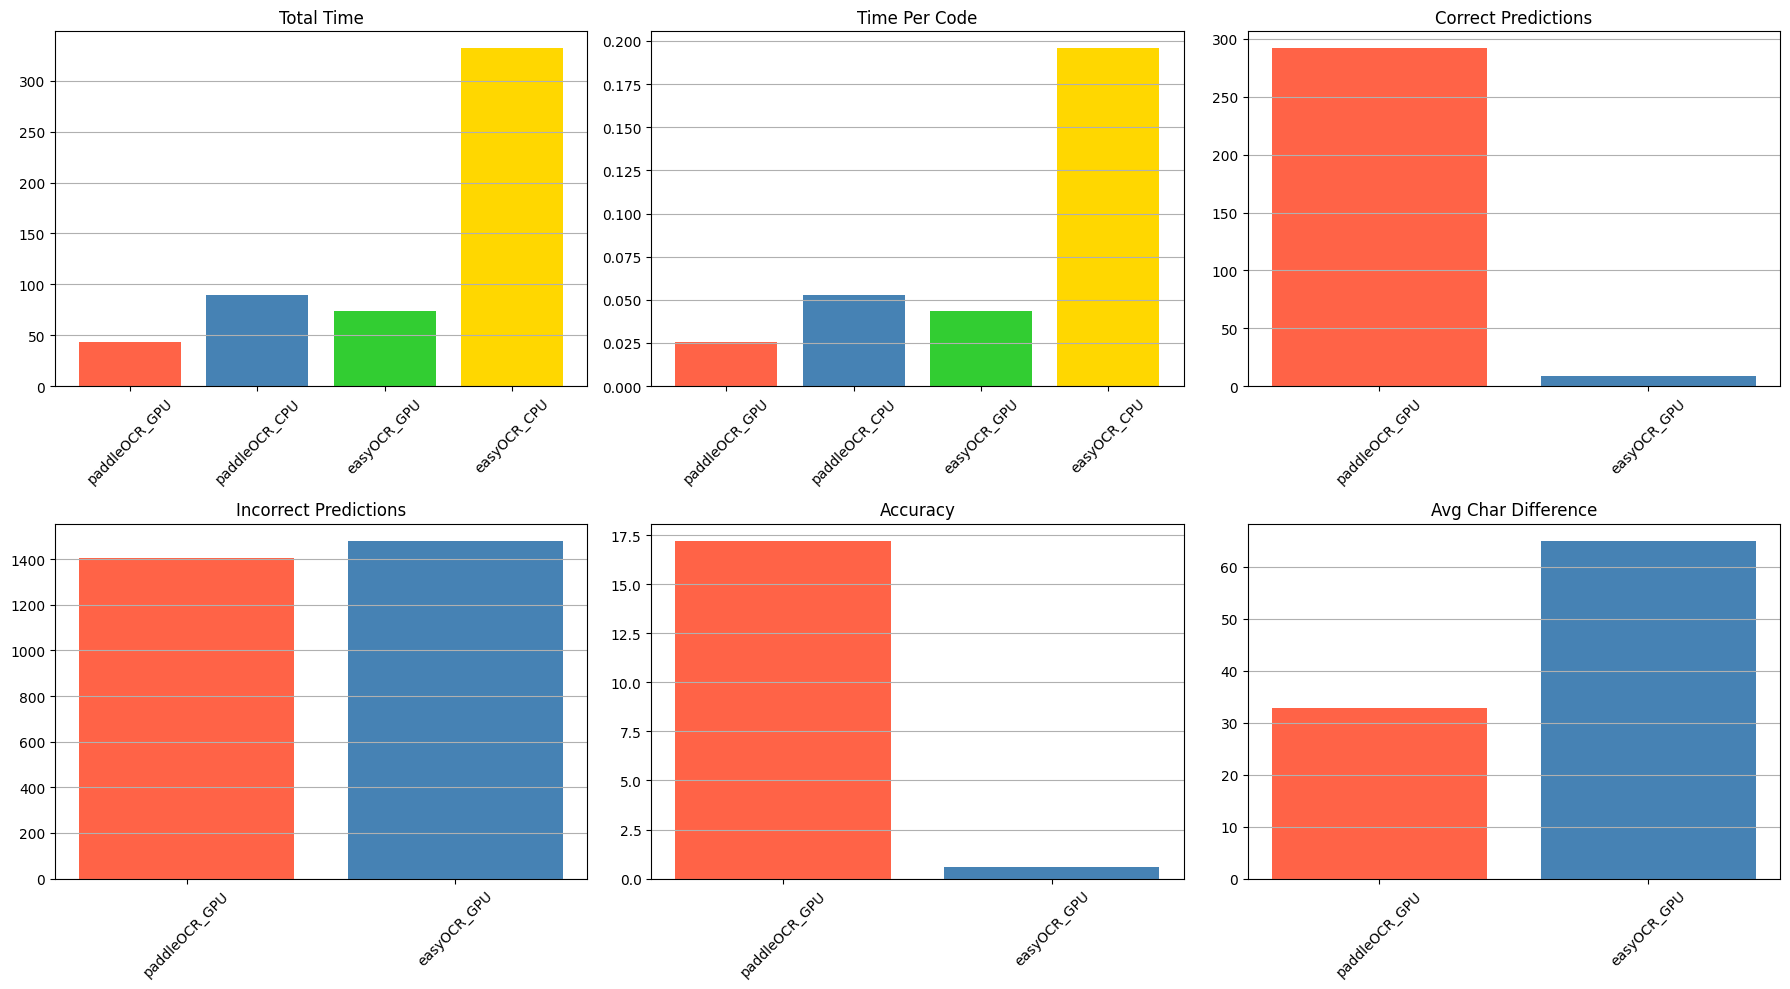

In [52]:
import matplotlib.pyplot as plt

# Define the specific order for the models and the colors
model_order = ['paddleOCR_GPU', 'paddleOCR_CPU', 'easyOCR_GPU', 'easyOCR_CPU']
colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700']  # Different colors for each bar

# Extract the list of metrics to plot
metrics = ['total_time', 'time_per_code', 'correct_predictions', 'incorrect_predictions', 'accuracy', 'avg_char_difference']

# Prepare the data for plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    if metric == 'time_per_code' or metric == 'total_time':
        # For time_per_code and total_time, plot all 4 models
        values = [results[model][metric] for model in model_order]
        labels = model_order
        ax_color = colors  # Assign colors to all models
    else:
        # For other metrics, only plot for GPU models
        values = [results[model][metric] for model in ['paddleOCR_GPU', 'easyOCR_GPU']]
        labels = ['paddleOCR_GPU', 'easyOCR_GPU']
        ax_color = ['#FF6347', '#4682B4']  # Assign custom colors for just the GPU models

    axes[i].bar(labels, values, color=ax_color)
    axes[i].set_title(metric.replace('_', ' ').title())
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, axis='y')

plt.tight_layout()
plt.show()
